<center><img src='cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center> Detection de points de fuite dans des images de routes </center>
<hr style=" border:none; height:3px;">
</h1>




L'objectif de ce projet est de faire un état de l'art sur les approches actuelles de détection de points de fuite et proposer une démarche particulière (à déterminer) en utilisant les techniques de traitement d'images vues en cours .

## **Qu'est ce que le vnp (Vanishing Point Detection) ?**

Ici une petite intro au projet (explication du VNP, pourquoi on fait le VNP, etc)

## **Objectifs définis pour le projet**

Ici citer les'différents objectifs (tq utiliser les techniques de traitement d'images vu en cours pour simplifier le problème, ...etc) 

## **Carte des données (Dataset Card)**

### Aperçu

Le dataset contient un total de 219 images, réparties en différents sous-ensembles pour les besoins de l'apprentissage automatique :
- Ensemble d'entraînement : 154 images
- Ensemble de validation : 43 images
- Ensemble de test : 22 images

Chaque image est annotée avec les classes suivantes telles que définies dans le fichier `classes.csv` :
- `road-lane`
- `road-line`
- `railing`
- `background`
- **`vnp`** (Classe d'intérêt pour le projet)
- `zebra`

Les annotations présentes dans le dataset sont essentielles pour l'identification et la classification des différents éléments routiers, en particulier pour la détection du point de fuite qui est l'intérêt principal du projet.

### Accès

Le dataset est téléchargeable à l'URL suivante : [Vanishing Point and Road Detection Dataset](https://universe.roboflow.com/vanishing-point-and-road-detection/vanishingpointdetection)

Lors de la tentative de téléchargement du dataset, une fenêtre pop-up offre deux options pour le format des annotations :
- Segmentation JSON COCO
- Masques de segmentation sémantique MASK (L'option pour laquelle nous avons opté)

### Citation

Les chercheurs utilisant ce dataset dans leurs travaux doivent le citer de la manière suivante :

```bibtex
@misc{vanishingpointdetection_dataset,
  title = {VanishingPointDetection Dataset},
  type = {Open Source Dataset},
  author = {Vanishing Point and road detection},
  howpublished = {\url{https://universe.roboflow.com/vanishing-point-and-road-detection/vanishingpointdetection}},
  url = {https://universe.roboflow.com/vanishing-point-and-road-detection/vanishingpointdetection},
  journal = {Roboflow Universe},
  publisher = {Roboflow},
  year = {2023},
  month = {aug},
  note = {consulté le 2024-04-07},
}


## **Analyse du Dataset** 

In [1]:
#Créons un chemin pour le dossier Dataset à l'aide du module os

import os
path = os.getcwd() + '/Dataset'
print(path)

c:\Users\Maamar\Desktop\VanishingPointDetection_CS/Dataset


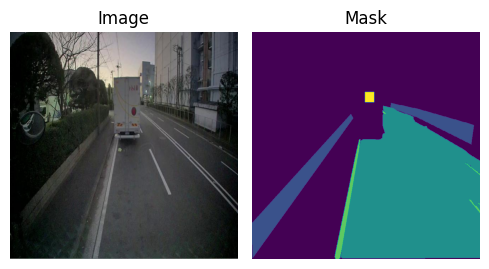

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

image_path_1 = path + '/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160.jpg'
image_path_2 = path + '/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160_mask.png'

image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)


fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot the first image
axes[0].imshow(image_1)
axes[0].axis('off')  # Hide axes for image 1
axes[0].set_title('Image') # Optional title

# Plot the second image
axes[1].imshow(image_2)
axes[1].axis('off')  # Hide axes for image 2
axes[1].set_title('Mask') # Optional title

# Display the images
plt.tight_layout()
plt.show()


Appliquons une approche naïve pour tenter de trouver le point de fuite dans cette image.

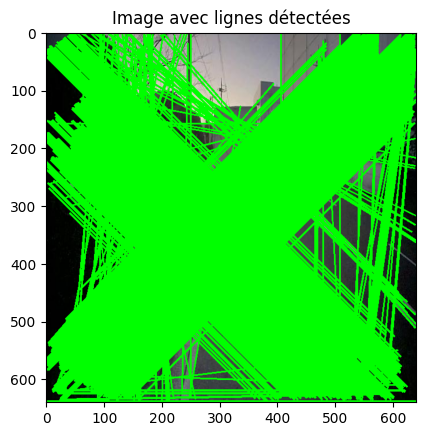

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image_path = image_path_1
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Égalisation d'histogramme (optionnelle pour améliorer le contraste)
equalized_image = cv2.equalizeHist(gray_image)

# Appliquer le filtre de Canny pour détecter les bords
edges = cv2.Canny(equalized_image, 50, 150, apertureSize=3)

# Utiliser la transformée de Hough pour détecter les lignes dans l'image
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=10, maxLineGap=250)

# Appliquer le filtre de Sobel pour le filtrage spatial
sobelx = cv2.Sobel(equalized_image, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(equalized_image, cv2.CV_64F, 0, 1, ksize=5)

# Trouver les intersections des lignes pour calculer le point de fuite
intersections = []
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            intersections.append((x1, y1))
            intersections.append((x2, y2))

# Affichage de l'image originale avec les lignes détectées
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec lignes détectées')
plt.show()


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


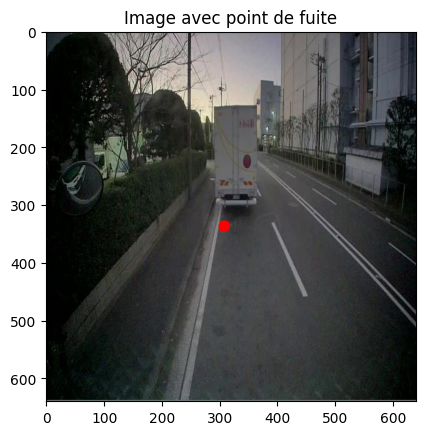

In [12]:
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt

# Appliquer K-means clustering
# Le nombre de clusters (n_clusters) est arbitraire; vous pourriez avoir besoin de l'ajuster
kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

# Le centre du cluster représente le point de fuite
vanishing_point = kmeans.cluster_centers_

# Charger l'image originale
image_path = image_path_1
image = cv2.imread(image_path)

# Dessiner le point de fuite sur l'image
cv2.circle(image, (int(vanishing_point[0][0]), int(vanishing_point[0][1])), 10, (0, 0, 255), -1)

# Afficher l'image avec le point de fuite
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec point de fuite')
plt.show()
